In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
from statsmodels.tsa.seasonal import STL
from scipy import signal
import pingouin as pg
pd.set_option('display.max_rows', None)
from statsmodels.stats.weightstats import ttest_ind
from tqdm.notebook import tqdm

# loading news and data

In [17]:
start_date = '2014-12-30'
end_date = '2022-01-09'

In [18]:
spx_index = DataReader('^GSPC', 'yahoo', start_date, end_date)['Adj Close']
spx_returns = spx_index.pct_change().dropna()

# Data density and distribution functions

<AxesSubplot:ylabel='Density'>

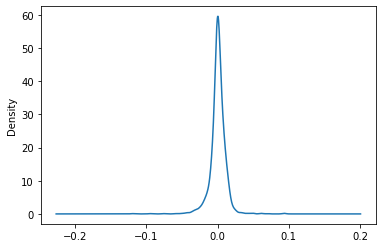

In [19]:
spx_returns.plot(kind='kde')

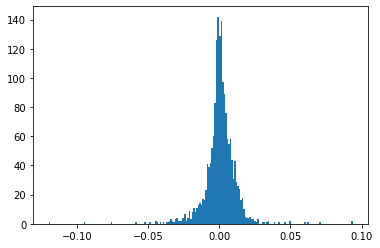

In [20]:
plt.hist(spx_returns, bins=200)
plt.show()

In [22]:
# scipy.stats.normaltest(spx_returns)
rng = np.random.default_rng()
k2, p = st.normaltest(spx_returns)
alpha = 1e-3
print("p = {:g}".format(p))
p = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 7.29083e-121
The null hypothesis cannot be rejected


# Confidence interval without considering trend influence

In [8]:
conf_int = st.t.interval(alpha=0.95, df=len(spx_returns)-1, loc=np.mean(spx_returns), scale=np.std(spx_returns))

In [24]:
outliers_negative = spx_returns[spx_returns <= conf_int[0]]
outliers_positive = spx_returns[spx_returns >= conf_int[1]]
outliers_conf_int = pd.concat([outliers_negative, outliers_positive], ignore_index=False)

In [10]:
spx_returns_date = spx_returns.reset_index(drop=False)
spx_index_date = spx_index.reset_index(drop=False)

# Looking for anomalies in n days intervals

In [11]:
#n - количества дней по каждую сторону от выбранной даты

n = 5

In [12]:
def dataframe_p_vals(n, alp=0.9):
    cols = ['date', 'p-val', 'return', 'conf_int_lower', 'conf_int_upper', 'conf_pred_lower', 'conf_pred_upper']
    df = pd.DataFrame(0, index=np.arange(len(spx_returns-(2*n-1))), columns=cols)
    df = df.reset_index(drop=False)
    for i in range(n, len(df)):
        n_pred = spx_returns[i - n:i - 1]
        n_post = spx_returns[i:i + (n - 1)]
        n_concat = pd.concat([n_pred, n_post])
        results = ttest_ind(n_pred, n_post)
        conf_int_ndays = st.t.interval(alpha=alp, df=len(n_concat)-1, loc=np.mean(n_concat), scale=np.std(n_concat))
        conf_pred = st.t.interval(alpha=alp, df=len(n_pred)-1, loc=np.mean(n_pred), scale=np.std(n_pred))
        df.iloc[i-n, list(df.columns).index('p-val')] = results[1].item(0)
        df.iloc[i-n, list(df.columns).index('date')] = spx_returns_date.iloc[i, 0]
        df.iloc[i-n, list(df.columns).index('conf_pred_lower')] = conf_pred[0]
        df.iloc[i-n, list(df.columns).index('conf_pred_upper')] = conf_pred[1]
        df.iloc[i-n, list(df.columns).index('conf_int_lower')] = conf_int_ndays[0]
        df.iloc[i-n, list(df.columns).index('conf_int_upper')] = conf_int_ndays[1]
        df.iloc[i-n, list(df.columns).index('return')] = spx_returns[i]

    p_values_spx = df[:-n]
    return p_values_spx

In [13]:
def confidence_within_2n_days(n):
    n_days_analysis_anom_conf = pd.DataFrame(columns=['date'])
    p_values_spx = dataframe_p_vals(n)

    for i in range(len(p_values_spx)):
        if p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] <= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_int_lower')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_anom_conf.loc[i] = new_row
        elif p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] >= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_int_upper')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_anom_conf.loc[i] = new_row 
    return n_days_analysis_anom_conf

In [14]:
def statistically_different_over_period(n):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_anom = p_values_spx[p_values_spx['p-val'] <= 0.1][['return', 'conf_int_lower', 'conf_int_upper', 'date', 'index']]
    n_days_analysis_anom_conf = confidence_within_2n_days(n)
    set11, set12 = set(n_days_analysis_anom['date']), set(n_days_analysis_anom_conf['date'])
    the_most_signif = pd.DataFrame(list(set11.intersection(set12)), columns=[str(f"{n} the_most_signif")])
    printing = f"number of news with significant influence over next {n} days: {len(set11.intersection(set12))}"
    return n_days_analysis_anom, printing, the_most_signif

In [15]:
def significant_after_period(n):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_after_period = pd.DataFrame(columns=['date'])

    for i in range(len(p_values_spx)):
        if p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] <= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_pred_lower')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_after_period.loc[i] = new_row
        elif p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] >= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_pred_upper')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_after_period.loc[i] = new_row    
    
    return n_days_analysis_after_period


In [16]:
N = [5, 10, 15, 20]
signif_influence = pd.DataFrame(0, index=np.arange(len(N)*10), columns=['0'])
for n in tqdm(N):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_anom_conf = confidence_within_2n_days(n)
    n_days_analysis_anom, printing, the_most_signif = statistically_different_over_period(n)
    n_days_analysis_after_period = significant_after_period(n)
    signif_influence = pd.concat([signif_influence,  n_days_analysis_anom_conf['date'].rename(f"price_{n}_days_befandaft_confint"), 
            n_days_analysis_anom['date'].rename(f"price_{n}_days_interval_effect"), 
            n_days_analysis_after_period['date'].rename(f"price_{n}_previous_days_confint")], axis=1)
    print(printing)

  0%|          | 0/4 [00:00<?, ?it/s]

number of news with significant influence over next 5 days: 7
number of news with significant influence over next 10 days: 12
number of news with significant influence over next 15 days: 12
number of news with significant influence over next 20 days: 13


In [17]:
signif_influence = signif_influence.drop(['0'], axis=1)
signif_influence = signif_influence.fillna(value='empty')

# Looking for anomalies via looking at data distribution (2 st devs)

In [11]:
spx_returns_mu = spx_returns_date['Adj Close'].mean()
spx_returns_dev = spx_returns_date['Adj Close'].std()
lower = spx_returns_mu - 2*spx_returns_dev
upper = spx_returns_mu + 2*spx_returns_dev

In [12]:
lower_anom = spx_returns_date[spx_returns_date['Adj Close'] <= lower][['Date', 'Adj Close']]
upper_anom = spx_returns_date[spx_returns_date['Adj Close'] >= upper][['Date', 'Adj Close']]
spx_anom_95 = pd.concat([lower_anom, upper_anom])
spx_anom_95 = spx_anom_95['Date'].reset_index(drop=True)

# Final table

In [46]:
# Creating new dataframe

cols = list(signif_influence.columns)
df_int = pd.DataFrame(0, index=spx_index.index, columns=cols)
df_int['price_two_sigma'] = 0
df_help = df_int.T
df_help['empty'] = 'empty'
df_int = df_help.T

In [47]:
# Putting 1 in the results column if a date matches

df_int.loc[spx_anom_95, 'price_two_sigma'] = 1
for col in list(signif_influence):
    df_int.loc[signif_influence[col], col] = 1
df_int = df_int[:-1]

In [48]:
# Summing all conditions

df_int['result'] = df_int.T.sum()
df_int_copy1 = df_int['result']
df_int_copy1.to_csv('by_price.csv')

In [49]:
# Creating columns by which we can get dates that satisfy at least either 1 or 2 conditions

df_int['by_price_days_with_at_least_1_value'] = 0
df_int['by_price_days_with_at_least_2_values'] = 0
df_int.loc[df_int.result > 0, 'by_price_days_with_at_least_1_value'] = 1
df_int.loc[df_int.result > 1, 'by_price_days_with_at_least_2_values'] = 1

In [50]:
df_int_copy = df_int[['by_price_days_with_at_least_1_value', 'by_price_days_with_at_least_2_values']]

#Get results for volume

In [ ]:
spx_index = DataReader('^GSPC', 'yahoo', start_date, end_date)['Volume']
spx_returns = spx_index.pct_change().dropna()

#Looking for anomalies in n days intervals¶

In [ ]:
n = 5

In [ ]:
def dataframe_p_vals(n):
    df = pd.DataFrame(0, index=np.arange(len(spx_returns-(2*n-1))), columns=['date', 'p-val', 'return', 'conf_int_lower', 'conf_int_upper', 'conf_pred_lower', 'conf_pred_upper'])
    df = df.reset_index(drop=False)
    for i in range(n, len(df)):
        n_pred = spx_returns[i - n:i - 1]
        n_post = spx_returns[i:i + (n - 1)]
        n_concat = pd.concat([n_pred, n_post])
        results = ttest_ind(n_pred, n_post)
        conf_int_ndays = st.t.interval(alpha=0.90, df=len(n_concat)-1, loc=np.mean(n_concat), scale=np.std(n_concat))
        conf_pred = st.t.interval(alpha=0.90, df=len(n_pred)-1, loc=np.mean(n_pred), scale=np.std(n_pred))
        df.iloc[i-n, list(df.columns).index('p-val')] = results[1].item(0)
        df.iloc[i-n, list(df.columns).index('date')] = spx_returns_date.iloc[i, 0]
        df.iloc[i-n, list(df.columns).index('conf_pred_lower')] = conf_pred[0]
        df.iloc[i-n, list(df.columns).index('conf_pred_upper')] = conf_pred[1]
        df.iloc[i-n, list(df.columns).index('conf_int_lower')] = conf_int_ndays[0]
        df.iloc[i-n, list(df.columns).index('conf_int_upper')] = conf_int_ndays[1]
        df.iloc[i-n, list(df.columns).index('return')] = spx_returns[i]

    p_values_spx = df[:-n]
    return p_values_spx

In [ ]:
def confidence_within_2n_days(n):
    n_days_analysis_anom_conf = pd.DataFrame(columns=['date'])
    p_values_spx = dataframe_p_vals(n)

    for i in range(len(p_values_spx)):
        if p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] <= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_int_lower')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_anom_conf.loc[i] = new_row
        elif p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] >= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_int_upper')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_anom_conf.loc[i] = new_row 
    return n_days_analysis_anom_conf

In [ ]:
def statistically_different_over_period(n):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_anom = p_values_spx[p_values_spx['p-val'] <= 0.1][['return', 'conf_int_lower', 'conf_int_upper', 'date', 'index']]
    n_days_analysis_anom_conf = confidence_within_2n_days(n)
    set11, set12 = set(n_days_analysis_anom['date']), set(n_days_analysis_anom_conf['date'])
    the_most_signif = pd.DataFrame(list(set11.intersection(set12)), columns=[str(f"{n} the_most_signif")])
    printing = f"number of news with significant influence over next {n} days: {len(set11.intersection(set12))}"
    return n_days_analysis_anom, printing, the_most_signif

In [ ]:
def significant_after_period(n):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_after_period = pd.DataFrame(columns=['date'])

    for i in range(len(p_values_spx)):
        if p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] <= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_pred_lower')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_after_period.loc[i] = new_row
        elif p_values_spx.iloc[i, list(p_values_spx.columns).index('return')] >= p_values_spx.iloc[i, list(p_values_spx.columns).index('conf_pred_upper')]:
            new_row = p_values_spx.iloc[i, list(p_values_spx.columns).index('date')]
            n_days_analysis_after_period.loc[i] = new_row    
    
    return n_days_analysis_after_period

In [ ]:
N = [5, 10, 15, 20]
signif_influence = pd.DataFrame(0, index=np.arange(len(N)*10), columns=['0'])
for n in tqdm(N):
    p_values_spx = dataframe_p_vals(n)
    n_days_analysis_anom_conf = confidence_within_2n_days(n)
    n_days_analysis_anom, printing, the_most_signif = statistically_different_over_period(n)
    n_days_analysis_after_period = significant_after_period(n)
    signif_influence = pd.concat([signif_influence,  n_days_analysis_anom_conf['date'].rename(f"volume_{n}_days_befandaft_confint"), 
            n_days_analysis_anom['date'].rename(f"volume_{n}_days_interval_effect"), 
            n_days_analysis_after_period['date'].rename(f"volume_{n}_previous_days_confint")], axis=1)
    print(printing)

In [ ]:
signif_influence = signif_influence.drop(['0'], axis=1)
signif_influence = signif_influence.fillna(value='empty')

#Looking for anomalies via looking at data distribution (2 st devs)

In [ ]:
spx_returns_mu = spx_returns_date['Volume'].mean()
spx_returns_dev = spx_returns_date['Volume'].std()
lower = spx_returns_mu - 2*spx_returns_dev
upper = spx_returns_mu + 2*spx_returns_dev

In [ ]:
lower_anom = spx_returns_date[spx_returns_date['Volume'] <= lower][['Date', 'Volume']]
upper_anom = spx_returns_date[spx_returns_date['Volume'] >= upper][['Date', 'Volume']]
spx_anom_95 = pd.concat([lower_anom, upper_anom])
spx_anom_95 = spx_anom_95['Date'].reset_index(drop=True)

#Final table

In [ ]:
# Creating new dataframe

cols = list(signif_influence.columns)
df_int2 = pd.DataFrame(0, index=spx_index.index, columns=cols)
#df_int['volume_two_sigma'] = 0
df_help2 = df_int2.T
df_help2['empty'] = 'empty'
df_int2 = df_help2.T

In [ ]:
# Putting 1 in the results column if a date matches

#df_int.loc[spx_anom_95, 'volume_two_sigma'] = 1
for col in list(signif_influence):
    df_int2.loc[signif_influence[col], col] = 1
df_int2 = df_int2[:-1]

In [ ]:
# Summing all conditions

df_int2['result'] = df_int2.T.sum()

In [ ]:
# Creating columns by which we can get dates that satisfy at least either 1 or 2 conditions

df_int2[['by_volume_days_with_at_least_1_value', 'by_volume_days_with_at_least_2_values']] = 0
df_int2.loc[df_int.result > 0, 'by_volume_days_with_at_least_1_value'] = 1
df_int2.loc[df_int.result > 1, 'by_volume_days_with_at_least_2_values'] = 1

#PELT

In [ ]:
k = spx_index.reset_index(drop='True')
k = k.to_numpy()
k1 = spx_returns.reset_index(drop='True')
k1 = k1.to_numpy()

In [ ]:
def normal_var(data, mean):
  
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    cumm = [0.0]
    cumm.extend(np.cumsum(np.power(np.abs(data - mean), 2)))

    def cost(s, t):
        dist = float(t - s)
        diff = cumm[t] - cumm[s]
        return dist * (np.log(2*math.pi)+np.log(diff/dist)+1)

    return cost

def normal_meanvar(data):

    data = np.hstack(([0.0], np.array(data)))

    cumm = np.cumsum(data)
    cumm_sq = np.cumsum([val**2 for val in data])

    def cost(s, t):
        ts_i = 1.0 / (t-s)
        mu = (cumm[t] - cumm[s]) * ts_i
        sig = (cumm_sq[t] - cumm_sq[s]) * ts_i - mu**2
        sig_i = 1.0 / sig
        return (t-s) * np.log(sig) + (cumm_sq[t] - cumm_sq[s]) * sig_i - 2*(cumm[t] - cumm[s])*mu*sig_i + ((t-s)*mu**2)*sig_i

    return cost

In [ ]:
def find_min(arr, val=0.0):
    return min(arr) + val, np.argmin(arr)

In [ ]:
def pelt(cost, length, pen=None):

    if pen is None:
        pen = 2 * np.log(length)

    F = np.zeros(length + 1)
    R = np.array([0], dtype=np.int64)
    candidates = np.zeros(length + 1, dtype=np.int64)

    F[0] = -pen

    for tstar in range(2, length + 1):
        cpt_cands = R
        seg_costs = np.zeros(len(cpt_cands))
        for i in range(0, len(cpt_cands)):
            seg_costs[i] = cost(cpt_cands[i], tstar)

        F_cost = F[cpt_cands] + seg_costs
        F[tstar], tau = find_min(F_cost, pen)
        candidates[tstar] = cpt_cands[tau]

        ineq_prune = [val < F[tstar] for val in F_cost]
        R = [cpt_cands[j] for j, val in enumerate(ineq_prune) if val]
        R.append(tstar - 1)
        R = np.array(R, dtype=np.int64)

    last = candidates[-1]
    changepoints = [last]
    while last > 0:
        last = candidates[last]
        changepoints.append(last)

    return sorted(changepoints)

In [ ]:
data_index = k
data_returns = k1
mean = 0.0
cost1 = normal_var(data_index, mean)
cost2 = normal_meanvar(data_index)
result1 = pelt(cost1, len(data_index))
result2 = pelt(cost2, len(data_index))
print(result1)
print(result2)

In [ ]:
final = pd.DataFrame(0, index=spx_index.index, columns=['numbers', 'pelt'])
final['numbers'] = spx_index.reset_index(drop=True).index
for i in result2:
    final.loc[(final['numbers'] == i), 'pelt'] = 1

#two st dev for SMA

In [ ]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

spx_index['SMA_20'] = sma(spx_index['Adj Close'], 5)
spx_index['SMA_20']

In [ ]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

spx_index['upper_bb'], spx_index['lower_bb'] = bb(spx_index['Adj Close'], spx_index['SMA_20'], 5)
spx_index.tail()

In [ ]:
spx_index['low_out'] = 0
spx_index['high_out'] = 0
spx_index.loc[spx_index['Low'] < spx_index['lower_bb'], 'low_out'] = 1
spx_index.loc[spx_index['High'] > spx_index['upper_bb'], 'high_out'] = 1
spx_index['outliers_from_tech'] = 0
spx_index.loc[spx_index['low_out'] == 1, 'outliers_from_tech'] = 1
spx_index.loc[spx_index['high_out'] == 1, 'outliers_from_tech'] = 1
spx_index['outliers_from_tech'].value_counts()

In [ ]:
spx_index_copy = spx_index['outliers_from_tech']

#Final results

In [ ]:
news = pd.read_csv('news_correct_date.csv')
price = df_int['by_price_days_with_at_least_2_values']
volume = df_int2['by_volume_days_with_at_least_2_values']
volume = volume.drop('Date', axis=1)
tech = spx_index['outliers_from_tech']
tech = tech.drop('Date', axis=1)
pelt = final['pelt']
pelt = pelt.drop('Date', axis=1)

In [ ]:
final_result = pd.concat([price, volume, tech, pelt], axis=1, ignore_index=False)
final_result.index = final_result['Date']
final_result['Date'] = pd.to_datetime(final_result.Date)

In [ ]:
final_result_copy = final_result.drop('Date', axis=1)
final_result['sum'] = final_result_copy.T.sum()

In [ ]:
final_result['target'] = 0
final_result.loc[final_result['sum'] > 2, 'target'] = 1

In [ ]:
#Сдвигаем даты для дней, когда были новости но не было торгов
listDatestarget = list(final_result[final_result['target']==1]['Date'])
listDatesSP500 = list(final_result['Date'])

news = pd.read_csv('news_correct_date.csv')
news['target'] = 0
news['date_shifted'] = np.nan
news['target_shifted'] = 0
news['date'] = pd.to_datetime(news.date)
listDatesNews = list(news['date'])
news.head()

In [ ]:
for i in listDatesSP500:
    news.loc[news['date'] == i, 'date_shifted'] = i

In [ ]:
news = news.fillna(method='bfill')

In [ ]:
for i in listDatestarget:
    news.loc[news['date'] == i, 'target'] = 1
    
    
for i in listDatestarget:
    news.loc[news['date_shifted'] == i, 'target_shifted'] = 1

In [ ]:
news = news.drop(['target', 'date_shifted'], axis=1)

In [ ]:
news.head()

In [ ]:
news.to_csv('result.csv')